In [31]:
import numpy as np
import pandas_datareader as web
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import yfinance as yf

In [32]:
# using JD as its not as stable
df_g = yf.download('AAPL', start='2015-07-01', end='2023-10-27')

[*********************100%%**********************]  1 of 1 completed


In [33]:
print(df_g)

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2015-07-01   31.725000   31.735001   31.497499   31.650000   28.599478   
2015-07-02   31.607500   31.672501   31.442499   31.610001   28.563324   
2015-07-06   31.235001   31.557501   31.212500   31.500000   28.463928   
2015-07-07   31.472500   31.537500   30.942499   31.422501   28.393904   
2015-07-08   31.120001   31.160000   30.635000   30.642500   27.689081   
...                ...         ...         ...         ...         ...   
2023-10-20  175.309998  175.419998  172.639999  172.880005  172.880005   
2023-10-23  170.910004  174.009995  169.929993  173.000000  173.000000   
2023-10-24  173.050003  173.669998  171.449997  173.440002  173.440002   
2023-10-25  171.880005  173.059998  170.649994  171.100006  171.100006   
2023-10-26  170.369995  171.380005  165.669998  166.889999  166.889999   

               Volume  
Date         

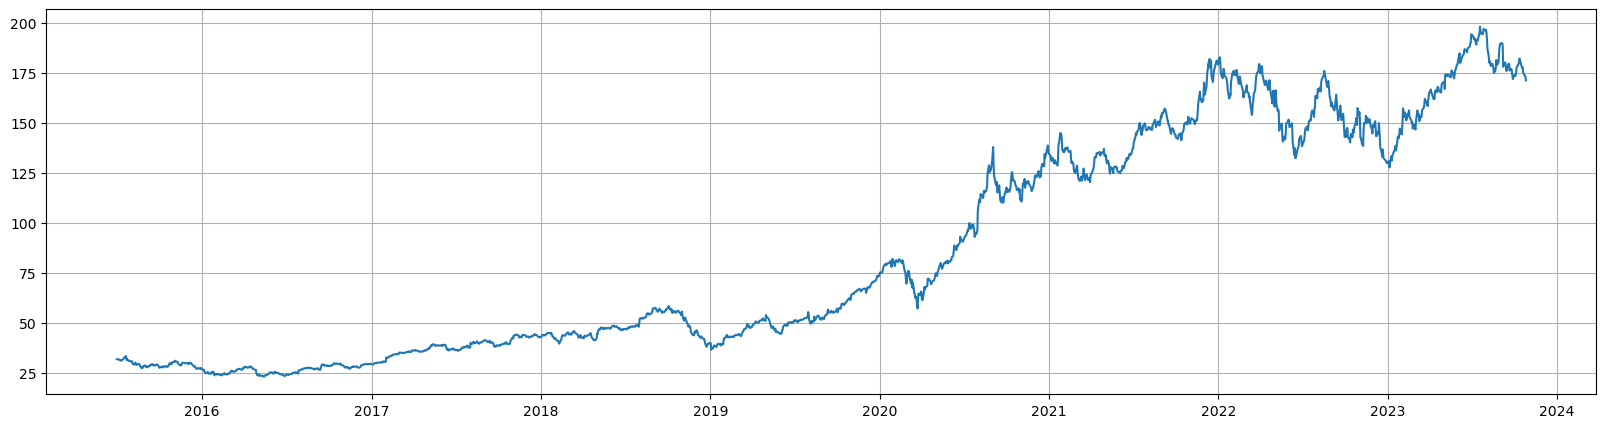

In [34]:
plt.figure(figsize=(20,5))
plt.plot(df_g.High)
plt.grid()

In [35]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,0.75))
# 0.75 so it's easier for relu to reach

# closing values
ser = df_g.Close.values
ser = ser.reshape(-1,1)
# scaled series
series = scaler.fit_transform(ser)

In [36]:
int(series.shape[0]*0.9)

1886

In [37]:
# fixed input size to model, last 30 days
Window = 30
Predday = 7

# To split the data into 90:10
Trainsplit = 0.9

cut = int(series.shape[0]*Trainsplit)

# train
closetrain = series[:cut]
# test
closetest = series[cut:-(Window+Predday)]
# forecast for future 7 days
closeforecast = series[-(Window+Predday):]

closetrain.shape, closetest.shape , closeforecast.shape

((1886, 1), (173, 1), (37, 1))

In [38]:
def windowed_dataset(series, window_size = 31,predday = 7, batch_size = 32, shuffle_buffer= 1000):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + predday, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + predday))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-7], tf.squeeze(w[-7:])))
    return ds.batch(batch_size).prefetch(3)

trainbatches =  windowed_dataset(closetrain)
testbatches =  windowed_dataset(closetest,batch_size=8)


In [39]:
testbatches

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=<unknown>, dtype=tf.float64, name=None))>

In [40]:
from tensorflow.keras import layers

tf.keras.backend.clear_session()

tf.random.set_seed(7)
np.random.seed(7)

model = tf.keras.Sequential()
model.add(layers.Conv1D(128,5,1,padding = "causal",activation = "relu",input_shape=[None, 1]))
for j in [128,128]:
    model.add(layers.LSTM(j, return_sequences=True))
model.add(layers.LSTM(128))
for i in [64,64,7]:
    model.add(layers.Dense(i, activation="selu"))

print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 128)         768       
                                                                 
 lstm (LSTM)                 (None, None, 128)         131584    
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 7)                 4

In [41]:
optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
kl = l = tf.keras.losses.LogCosh()
model.compile(optimizer = 'adam', loss =tf.keras.losses.Huber(), metrics=["mse"])
h = model.fit(trainbatches,epochs=100,validation_data=testbatches,verbose=1)
hist = h.history

Epoch 1/100
58/58 [==============================] - 6s 68ms/step - loss: 7.0519e-04 - mse: 0.0014 - val_loss: 0.0042 - val_mse: 0.0084
Epoch 2/100
58/58 [==============================] - 4s 63ms/step - loss: 5.5300e-04 - mse: 0.0011 - val_loss: 0.0044 - val_mse: 0.0087
Epoch 3/100
58/58 [==============================] - 4s 70ms/step - loss: 4.8173e-04 - mse: 9.6345e-04 - val_loss: 4.6588e-04 - val_mse: 9.3176e-04
Epoch 4/100
58/58 [==============================] - 4s 65ms/step - loss: 2.9871e-04 - mse: 5.9743e-04 - val_loss: 5.0916e-04 - val_mse: 0.0010
Epoch 5/100
58/58 [==============================] - 4s 63ms/step - loss: 2.5790e-04 - mse: 5.1581e-04 - val_loss: 3.1922e-04 - val_mse: 6.3844e-04
Epoch 6/100
58/58 [==============================] - 4s 63ms/step - loss: 3.2630e-04 - mse: 6.5261e-04 - val_loss: 0.0013 - val_mse: 0.0025
Epoch 7/100
58/58 [==============================] - 4s 63ms/step - loss: 3.5316e-04 - mse: 7.0632e-04 - val_loss: 6.7515e-04 - val_mse: 0.0014
Epoc

In [42]:
for t in hist.keys():
    print(t)

loss
mse
val_loss
val_mse


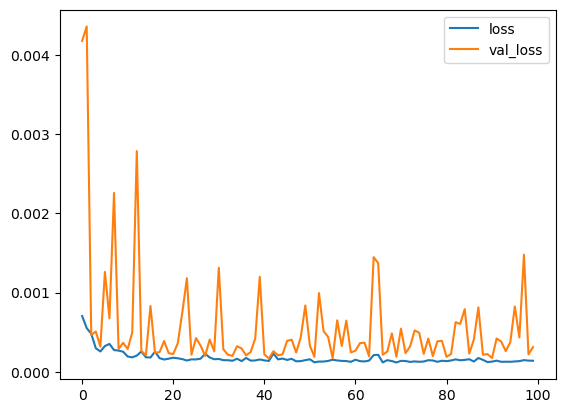

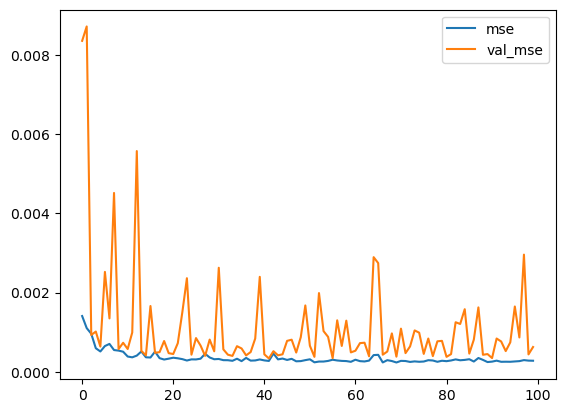

In [43]:
for i in ["loss","mse"]:
    plt.plot(hist[i],label = i)
    plt.plot(hist["val_"+i],label = "val_"+i)
    plt.legend()
    plt.show()


In [44]:
x1,y1 = next(iter(testbatches))
output = model.predict(x1)
output.shape

1/1 [==============================] - 1s 1s/step


(8, 7)

In [45]:
testbatches

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=<unknown>, dtype=tf.float64, name=None))>

1/1 [==============================] - 0s 32ms/step


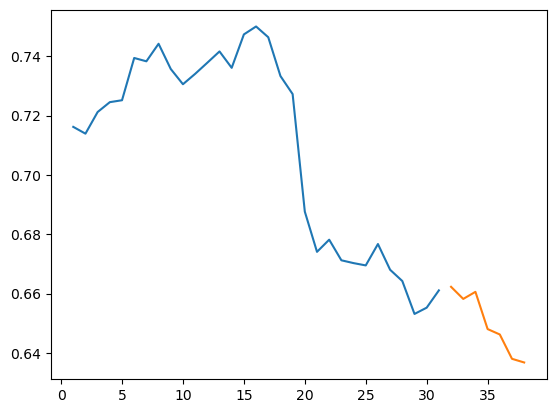

In [46]:
x1,y1 = next(iter(testbatches))
output = model.predict(x1)

time=list(range(1,32))
time2=list(range(32,39))
plt.plot(time,x1[0])
plt.plot(time2,output[0])

1/1 [==============================] - 0s 38ms/step


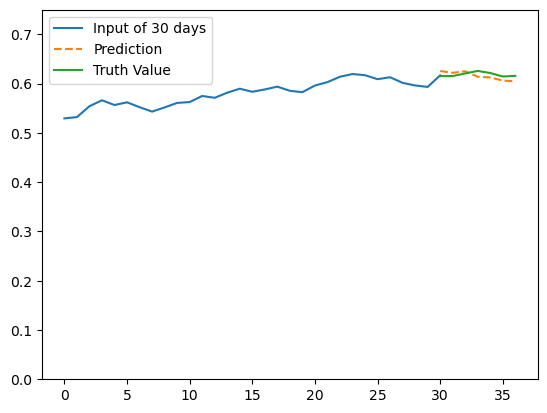

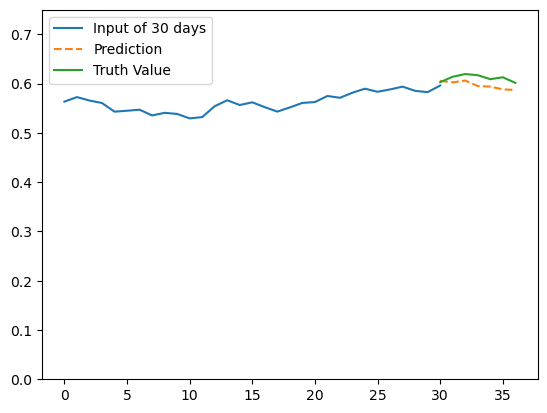

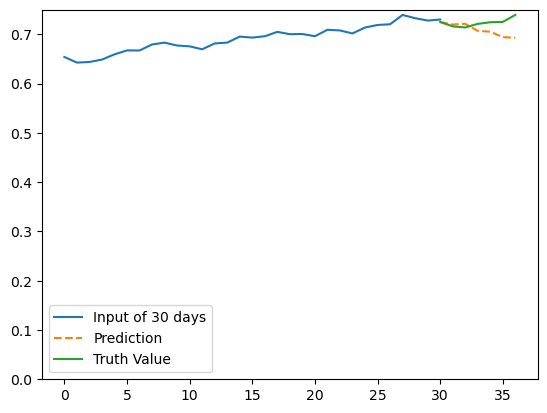

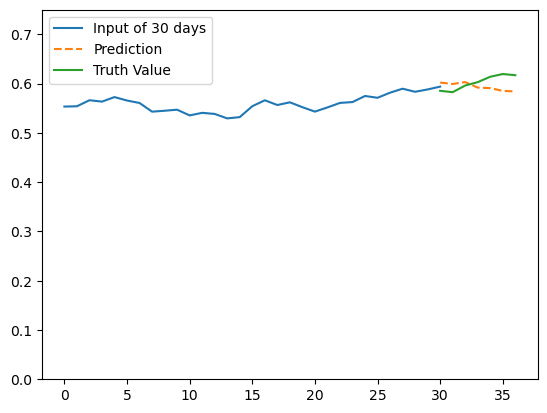

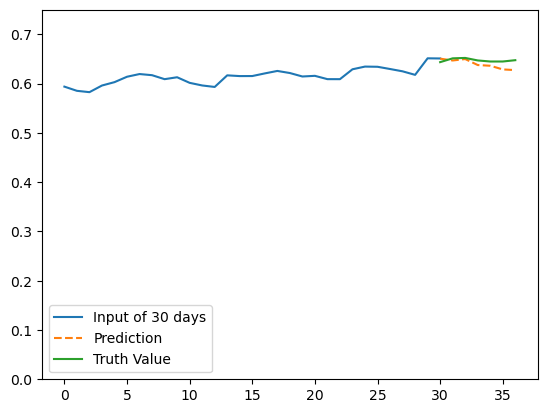

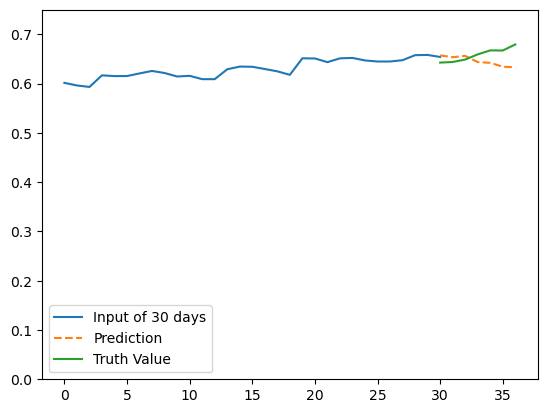

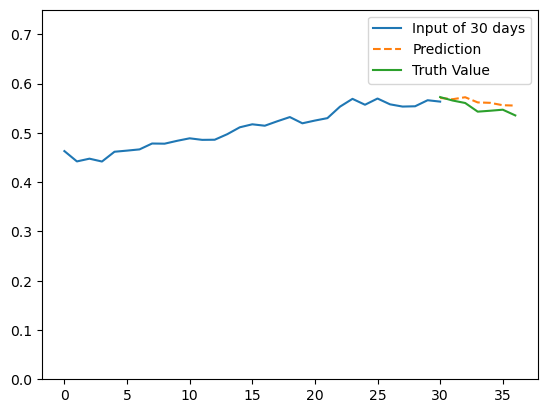

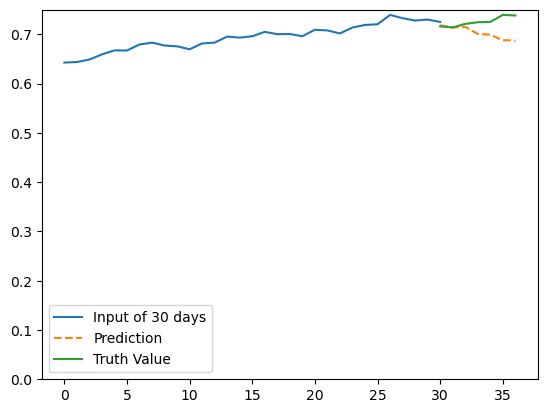

In [47]:
def visualplotloss(dataset):
    x,y = next(iter(dataset))
    output = model.predict(x)
    timecorr =list(range(30,37))
    for j in range(8):
        plt.ylim(0,0.75)
        plt.plot(x[j])
        plt.plot(timecorr,output[j],"--")
        plt.plot(timecorr,y[j])
        plt.legend(["Input of 30 days","Prediction","Truth Value"])
        plt.show()

visualplotloss(testbatches)

In [48]:
model.evaluate(testbatches)

17/17 [==============================] - 1s 25ms/step - loss: 3.1413e-04 - mse: 6.2826e-04


[0.0003141305933240801, 0.0006282611866481602]

1/1 [==============================] - 0s 42ms/step


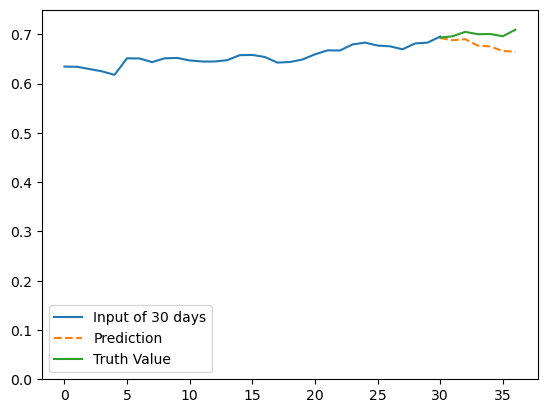

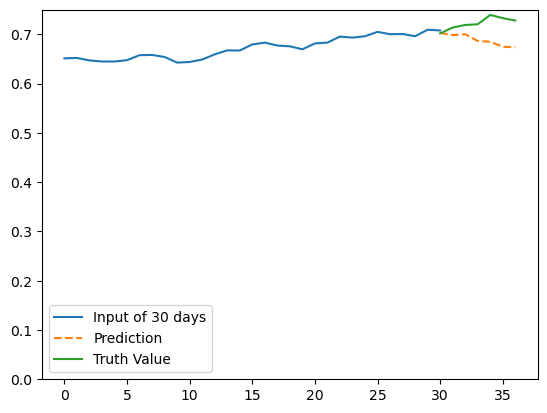

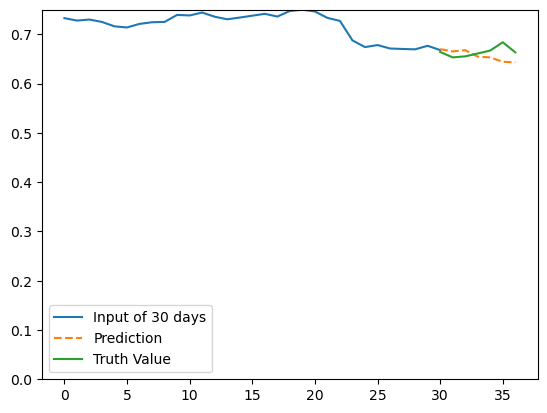

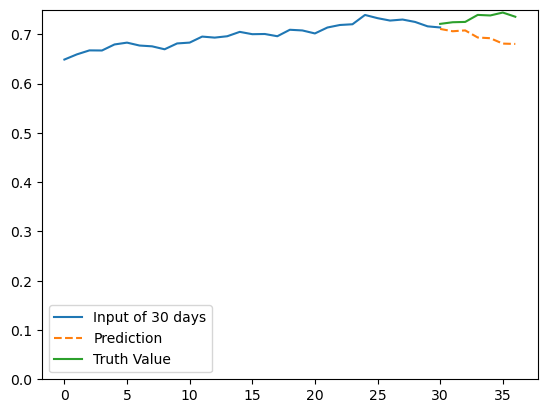

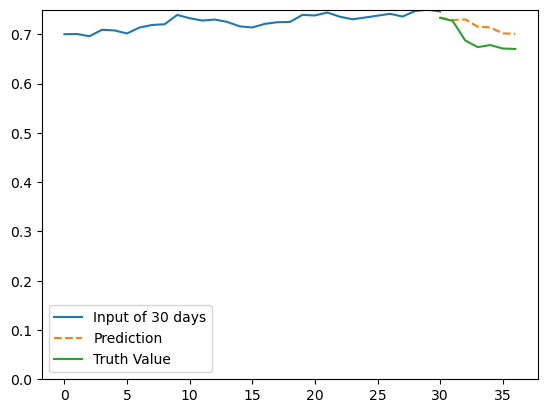

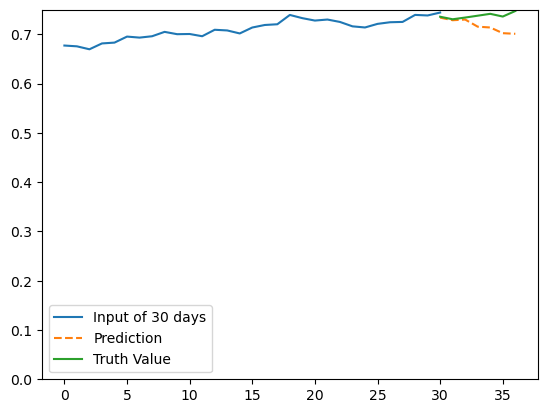

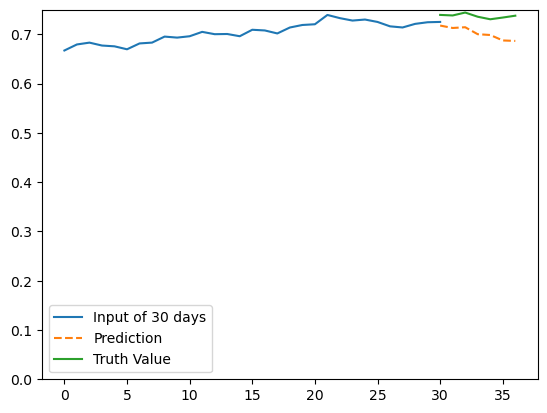

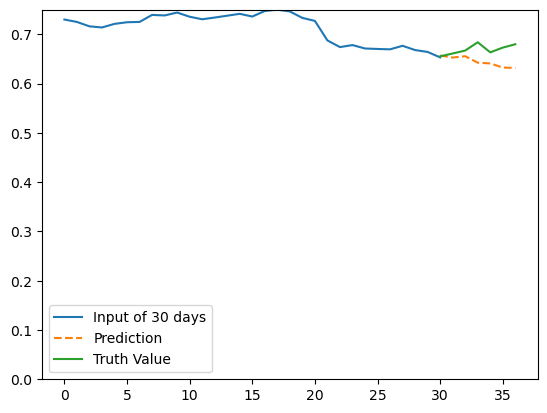

In [49]:
def visualplotloss(dataset):
    x,y = next(iter(dataset))
    output = model.predict(x)
    timecorr =list(range(30,37))
    for j in range(8):
        plt.ylim(0,0.75)
        plt.plot(x[j])
        plt.plot(timecorr,output[j],"--")
        plt.plot(timecorr,y[j])
        plt.legend(["Input of 30 days","Prediction","Truth Value"])
        plt.show()

visualplotloss(testbatches)

In [50]:
df_test=yf.download('GOOGL', start='2021-07-01', end='2023-10-27')

[*********************100%%**********************]  1 of 1 completed


In [51]:
len(df_test)

585

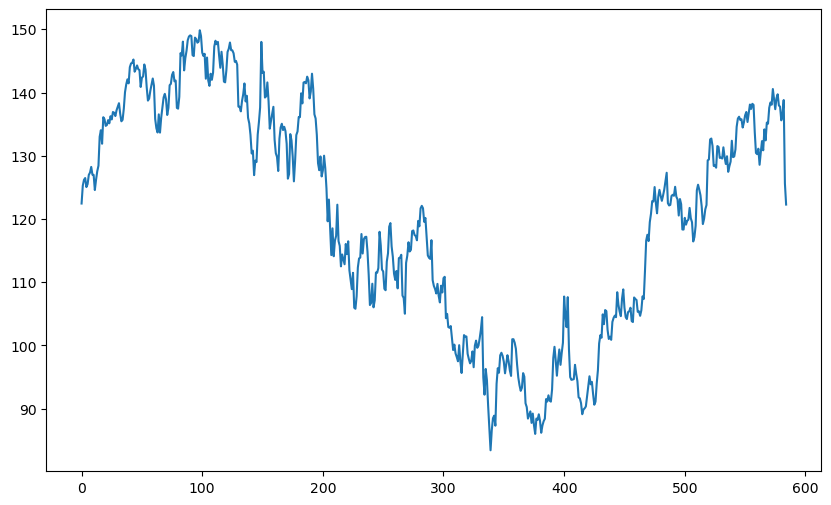

In [52]:
new_time_step=[]
for i in range(df_test.shape[0]):
    new_time_step.append(i)

close_data=df_test['Close']
new_time = np.array(new_time_step)
plt.figure(figsize=(10, 6))
plt.plot(new_time,close_data)

In [53]:
x_test=close_data
x_test=np.array(x_test).reshape(-1,1)

In [54]:
scaler1=MinMaxScaler(feature_range=(0,0.75))
xt1=scaler1.fit_transform(x_test)
xt1

array([[0.44061946],
       [0.47238869],
       [0.48292013],
       [0.48612751],
       [0.46997747],
       [0.47533637],
       [0.49179135],
       [0.49592483],
       [0.50603837],
       [0.49212446],
       [0.49172923],
       [0.46471463],
       [0.48314036],
       [0.49826833],
       [0.508122  ],
       [0.55999983],
       [0.57151949],
       [0.54740726],
       [0.59477318],
       [0.59119874],
       [0.57932908],
       [0.58077475],
       [0.58953301],
       [0.58383531],
       [0.59655196],
       [0.59075827],
       [0.60402276],
       [0.60282576],
       [0.59686267],
       [0.60719636],
       [0.61322149],
       [0.61979445],
       [0.60118243],
       [0.58748885],
       [0.59009756],
       [0.60985608],
       [0.63935531],
       [0.65313368],
       [0.66236619],
       [0.65515527],
       [0.68410667],
       [0.69073047],
       [0.69193884],
       [0.69778905],
       [0.67600911],
       [0.68111952],
       [0.68722944],
       [0.680

In [55]:
xt332=windowed_dataset(xt1)

1/1 [==============================] - 0s 30ms/step


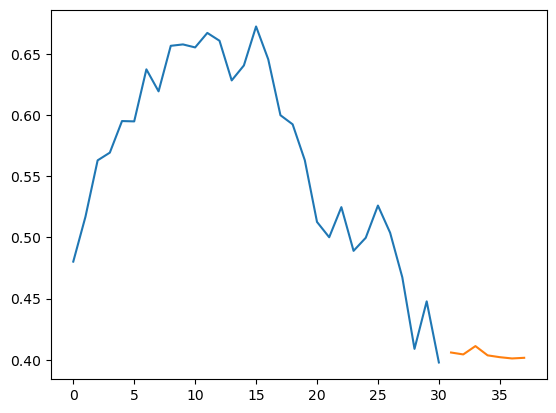

In [56]:
a,b=next(iter(xt332))
p=model.predict(a)
plt.plot(np.arange(0,31),a[0])
plt.plot(np.arange(31,38),p[0])

In [57]:
model.save('Model1_pred_7days.h5')

/Users/adityav/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [58]:
#Model 2:
def windowed_dataset1(series, window_size = 62,predday = 14, batch_size = 32, shuffle_buffer= 1000):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + predday, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + predday))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-14], tf.squeeze(w[-14:])))
    return ds.batch(batch_size).prefetch(3)

train2batches =  windowed_dataset1(closetrain)
test2batches =  windowed_dataset1(closetest,batch_size=8)

from tensorflow.keras import layers

tf.keras.backend.clear_session()

tf.random.set_seed(14)
np.random.seed(14)

model2 = tf.keras.Sequential()
model2.add(layers.Conv1D(128,5,1,padding = "causal",activation = "relu",input_shape=[None, 1]))
for j in [128,128]:
    model2.add(layers.LSTM(j, return_sequences=True))
model2.add(layers.LSTM(128))
for i in [64,64,14]:
    model2.add(layers.Dense(i, activation="selu"))

print(model2.summary())



optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
kl = l = tf.keras.losses.LogCosh()
model2.compile(optimizer = 'adam', loss =tf.keras.losses.Huber(), metrics=["mse"])
h1 = model2.fit(train2batches,epochs=20,validation_data=test2batches,verbose=1)
hist1 = h1.history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 128)         768       
                                                                 
 lstm (LSTM)                 (None, None, 128)         131584    
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 14)                9

None
Epoch 1/20
57/57 [==============================] - 23s 332ms/step - loss: 8.7128e-04 - mse: 0.0017 - val_loss: 0.0033 - val_mse: 0.0066
Epoch 2/20
57/57 [==============================] - 15s 253ms/step - loss: 4.8534e-04 - mse: 9.7068e-04 - val_loss: 0.0014 - val_mse: 0.0028
Epoch 3/20
57/57 [==============================] - 13s 219ms/step - loss: 4.3895e-04 - mse: 8.7789e-04 - val_loss: 5.2027e-04 - val_mse: 0.0010
Epoch 4/20
57/57 [==============================] - 13s 220ms/step - loss: 4.7187e-04 - mse: 9.4375e-04 - val_loss: 0.0024 - val_mse: 0.0048
Epoch 5/20
57/57 [==============================] - 13s 221ms/step - loss: 3.5326e-04 - mse: 7.0653e-04 - val_loss: 8.5449e-04 - val_mse: 0.0017
Epoch 6/20
57/57 [==============================] - 13s 227ms/step - loss: 3.8763e-04 - mse: 7.7525e-04 - val_loss: 0.0045 - val_mse: 0.0091
Epoch 7/20
57/57 [==============================] - 13s 228ms/step - loss: 4.4249e-04 - mse: 8.8498e-04 - val_loss: 0.0011 - val_mse: 0.0023
Epoc

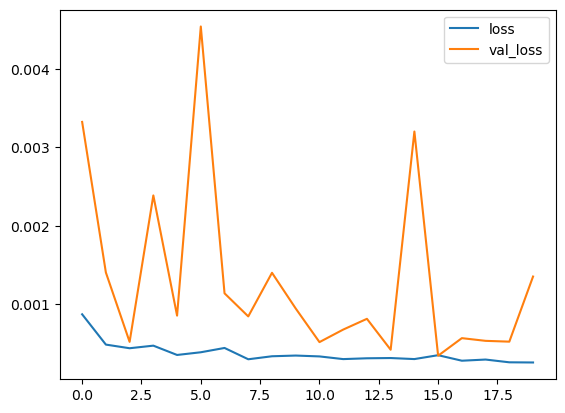

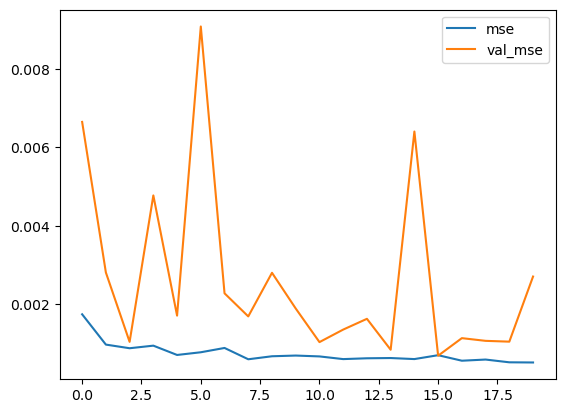

In [59]:
for i in ["loss","mse"]:
    plt.plot(hist1[i],label = i)
    plt.plot(hist1["val_"+i],label = "val_"+i)
    plt.legend()
    plt.show()

1/1 [==============================] - 1s 975ms/step


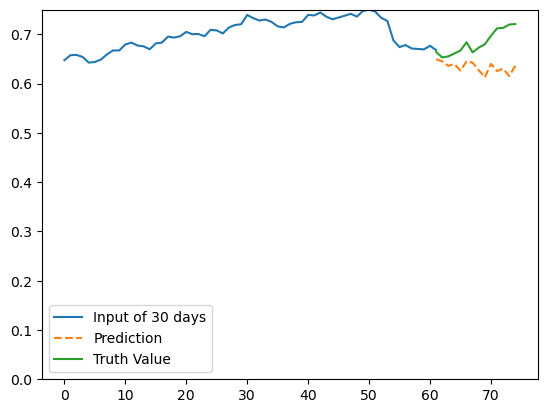

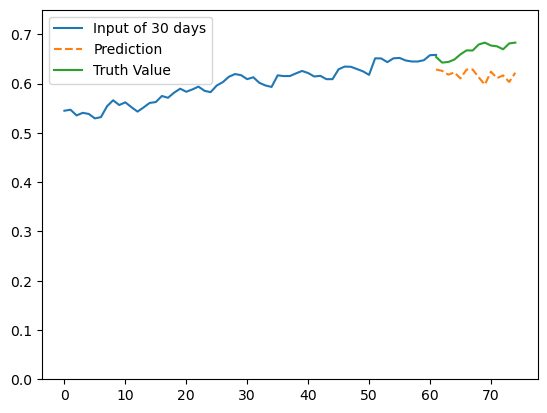

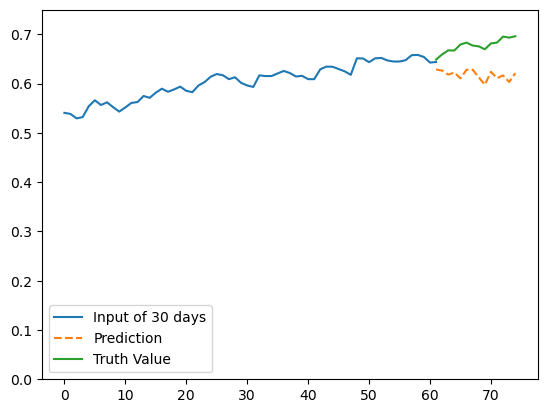

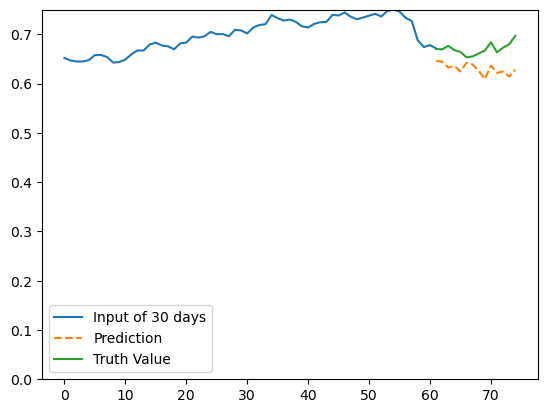

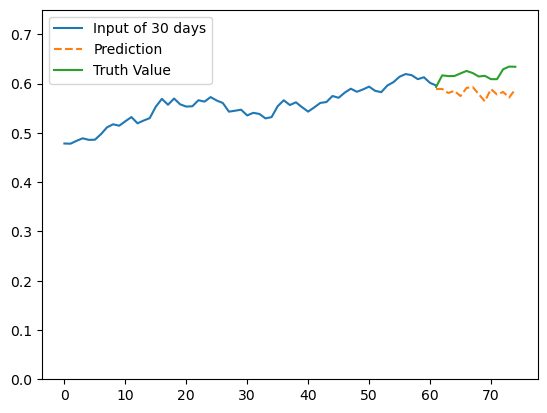

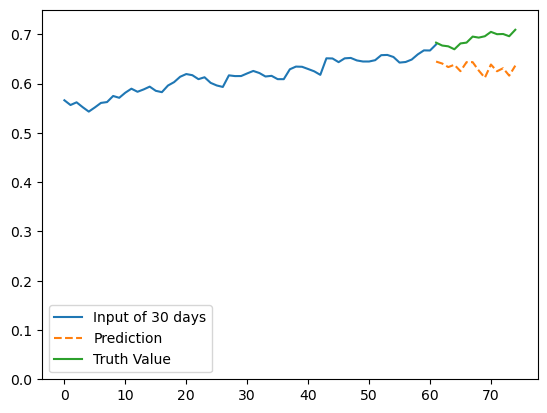

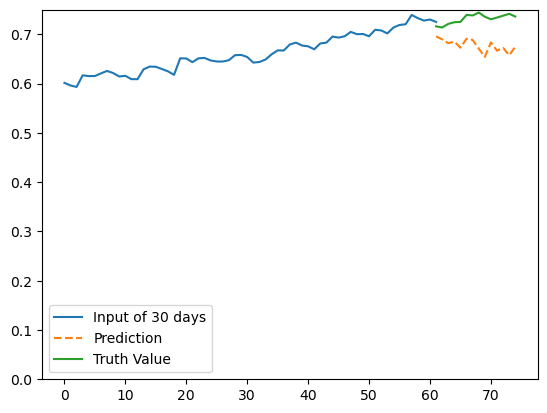

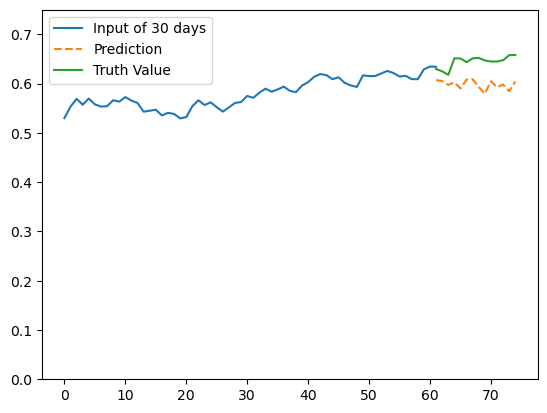

In [60]:
def visualplotloss2(dataset):
    x,y = next(iter(dataset))
    output = model2.predict(x)
    timecorr =list(range(61,75))
    for j in range(8):
        plt.ylim(0,0.75)
        plt.plot(x[j])
        plt.plot(timecorr,output[j],"--")
        plt.plot(timecorr,y[j])
        plt.legend(["Input of 30 days","Prediction","Truth Value"])
        plt.show()

visualplotloss2(test2batches)

1/1 [==============================] - 0s 61ms/step


Text(0.5, 1.0, 'Prediction for 14 Days')

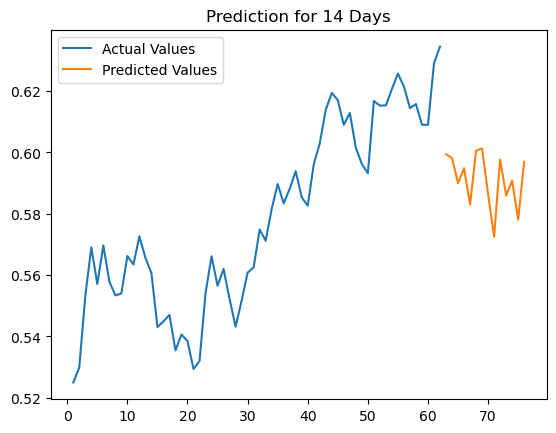

In [61]:
x2,y2 = next(iter(test2batches))
output2 = model2.predict(x2)

time=list(range(1,63))
time2=list(range(63,77))
plt.plot(time,x2[0])
plt.plot(time2,output2[0])
plt.legend(['Actual Values','Predicted Values'])
plt.title('Prediction for 14 Days')

In [62]:
model2.save('Model2_pred_14days.h5')

In [63]:
#Model 3:
def windowed_dataset2(series, window_size = 90,predday = 21, batch_size = 32, shuffle_buffer= 1000):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + predday, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + predday))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-21], tf.squeeze(w[-21:])))
    return ds.batch(batch_size).prefetch(3)

train3batches =  windowed_dataset2(closetrain)
test3batches =  windowed_dataset2(closetest,batch_size=8)

from tensorflow.keras import layers

tf.keras.backend.clear_session()

tf.random.set_seed(21)
np.random.seed(21)

model3 = tf.keras.Sequential()
model3.add(layers.Conv1D(128,5,1,padding = "causal",activation = "relu",input_shape=[None, 1]))
for j in [128,128]:
    model3.add(layers.LSTM(j, return_sequences=True))
model3.add(layers.LSTM(128))
for i in [64,64,21]:
    model3.add(layers.Dense(i, activation="selu"))

print(model3.summary())



optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
kl = l = tf.keras.losses.LogCosh()
model3.compile(optimizer = 'adam', loss ='mse', metrics=["mse"])
h2 = model3.fit(train3batches,epochs=30,validation_data=test3batches,verbose=1)
hist2 = h2.history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 128)         768       
                                                                 
 lstm (LSTM)                 (None, None, 128)         131584    
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 21)                1

None
Epoch 1/30
56/56 [==============================] - 21s 313ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 2/30
56/56 [==============================] - 17s 295ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 3/30
56/56 [==============================] - 17s 301ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 4/30
56/56 [==============================] - 20s 351ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 5/30
56/56 [==============================] - 18s 316ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 6/30
56/56 [==============================] - 18s 314ms/step - loss: 9.5763e-04 - mse: 9.5763e-04 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 7/30
56/56 [==============================] - 18s 313ms/step - loss: 8.8805e-04 - mse: 8.8805e-04 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 8/30
56/56 [==============================

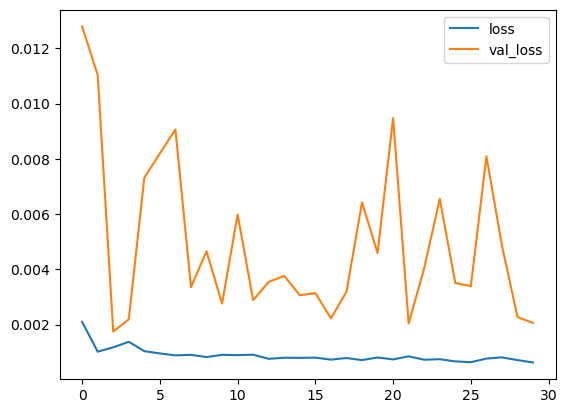

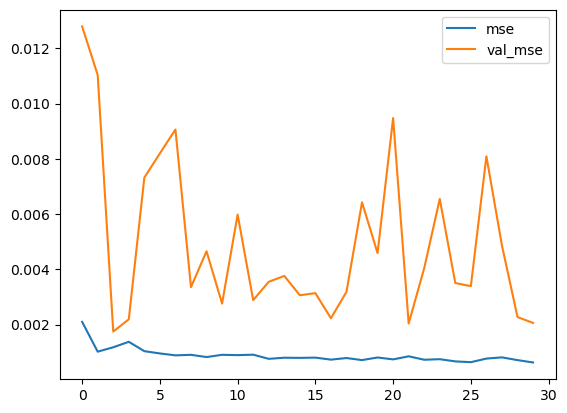

In [64]:
for i in ["loss","mse"]:
    plt.plot(hist2[i],label = i)
    plt.plot(hist2["val_"+i],label = "val_"+i)
    plt.legend()
    plt.show()

1/1 [==============================] - 1s 915ms/step


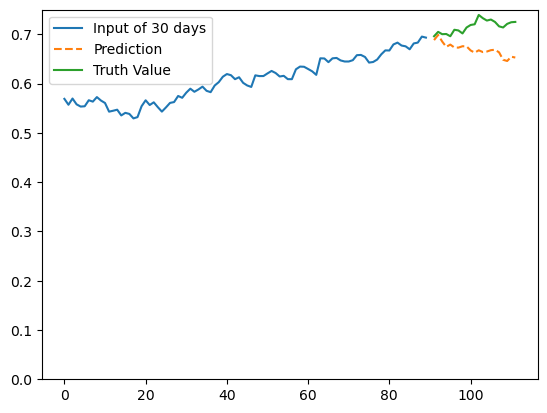

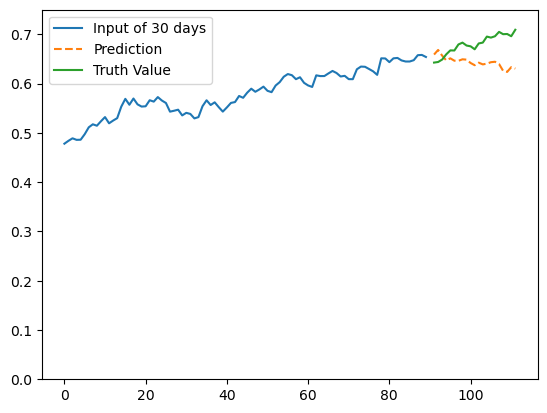

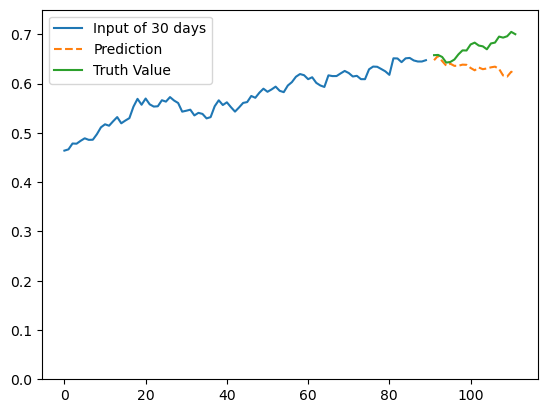

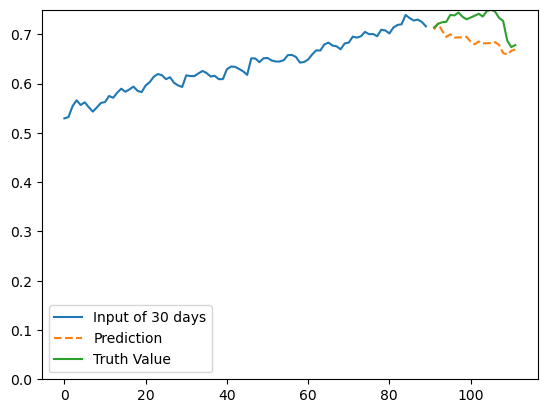

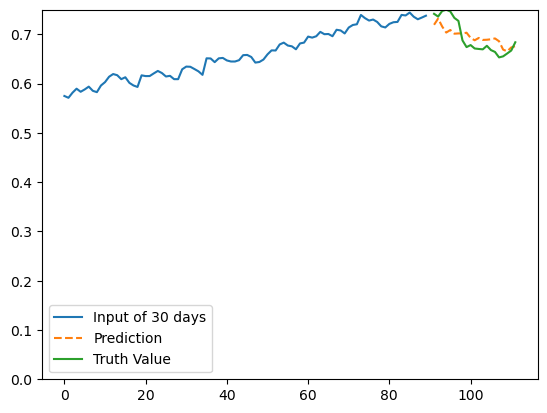

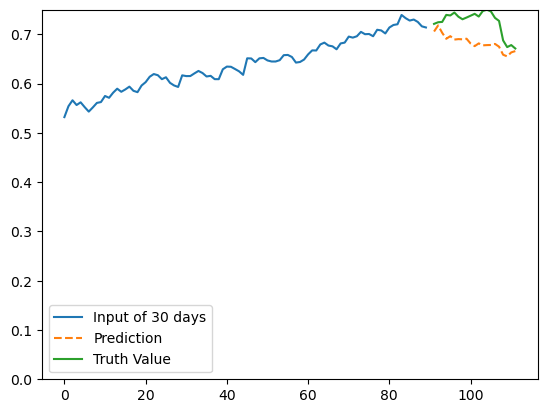

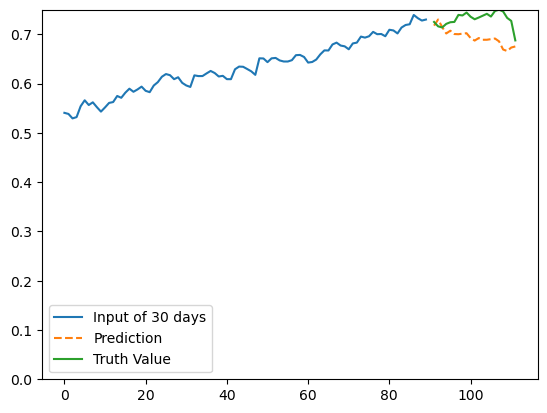

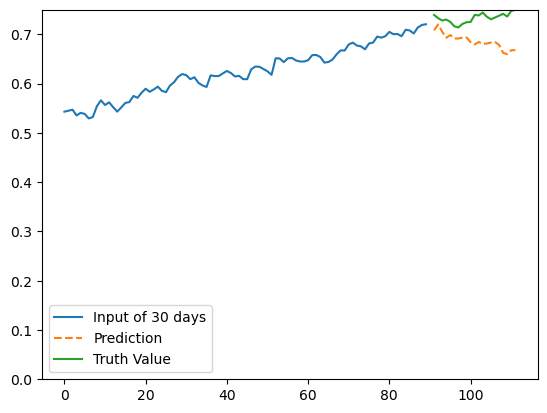

In [65]:
def visualplotloss3(dataset):
    x,y = next(iter(dataset))
    output = model3.predict(x)
    timecorr =list(range(91,112))
    for j in range(8):
        plt.ylim(0,0.75)
        plt.plot(x[j])
        plt.plot(timecorr,output[j],"--")
        plt.plot(timecorr,y[j])
        plt.legend(["Input of 30 days","Prediction","Truth Value"])
        plt.show()

visualplotloss3(test3batches)

1/1 [==============================] - 0s 80ms/step


Text(0.5, 1.0, 'Prediction for 21 Days')

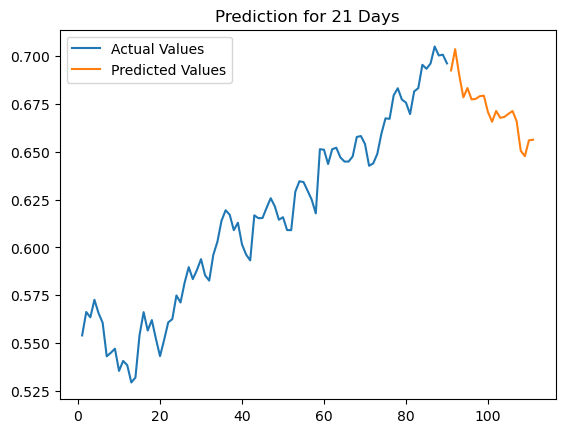

In [66]:
x3,y3 = next(iter(test3batches))
output3 = model3.predict(x3)

time=list(range(1,91))
time2=list(range(91,112))
plt.plot(time,x3[0])
plt.plot(time2,output3[0])
plt.legend(['Actual Values','Predicted Values'])
plt.title('Prediction for 21 Days')

In [67]:
model3.save('Model_3_Pred21_Days.h5')

In [68]:
#Model 4:
def windowed_dataset3(series, window_size = 120,predday = 28, batch_size = 32, shuffle_buffer= 1000):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + predday, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + predday))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-28], tf.squeeze(w[-28:])))
    return ds.batch(batch_size).prefetch(3)

train4batches =  windowed_dataset3(closetrain)
test4batches =  windowed_dataset3(closetest,batch_size=8)

from tensorflow.keras import layers

tf.keras.backend.clear_session()

tf.random.set_seed(28)
np.random.seed(28)

model4 = tf.keras.Sequential()
model4.add(layers.Conv1D(128,5,1,padding = "causal",activation = "relu",input_shape=[None, 1]))
for j in [128,128]:
    model4.add(layers.LSTM(j, return_sequences=True))
model4.add(layers.LSTM(128))
for i in [64,64,28]:
    model4.add(layers.Dense(i, activation="selu"))

print(model4.summary())



optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
kl = l = tf.keras.losses.LogCosh()
model4.compile(optimizer = 'adam', loss =tf.keras.losses.Huber(), metrics=["mse"])
h3 = model4.fit(train4batches,epochs=20,validation_data=test4batches,verbose=1)
hist3 = h3.history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 128)         768       
                                                                 
 lstm (LSTM)                 (None, None, 128)         131584    
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 28)                1

None
Epoch 1/20
55/55 [==============================] - 24s 370ms/step - loss: 0.0014 - mse: 0.0027 - val_loss: 0.0042 - val_mse: 0.0083
Epoch 2/20
55/55 [==============================] - 19s 350ms/step - loss: 9.6407e-04 - mse: 0.0019 - val_loss: 0.0091 - val_mse: 0.0182
Epoch 3/20
55/55 [==============================] - 22s 405ms/step - loss: 6.6540e-04 - mse: 0.0013 - val_loss: 0.0042 - val_mse: 0.0084
Epoch 4/20
55/55 [==============================] - 22s 389ms/step - loss: 5.7677e-04 - mse: 0.0012 - val_loss: 0.0014 - val_mse: 0.0029
Epoch 5/20
55/55 [==============================] - 20s 368ms/step - loss: 6.9970e-04 - mse: 0.0014 - val_loss: 0.0039 - val_mse: 0.0079
Epoch 6/20
55/55 [==============================] - 21s 374ms/step - loss: 5.5658e-04 - mse: 0.0011 - val_loss: 0.0010 - val_mse: 0.0020
Epoch 7/20
55/55 [==============================] - 20s 366ms/step - loss: 6.4552e-04 - mse: 0.0013 - val_loss: 5.9333e-04 - val_mse: 0.0012
Epoch 8/20
55/55 [==================

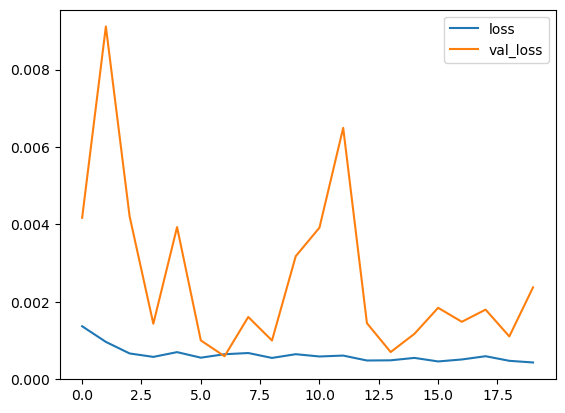

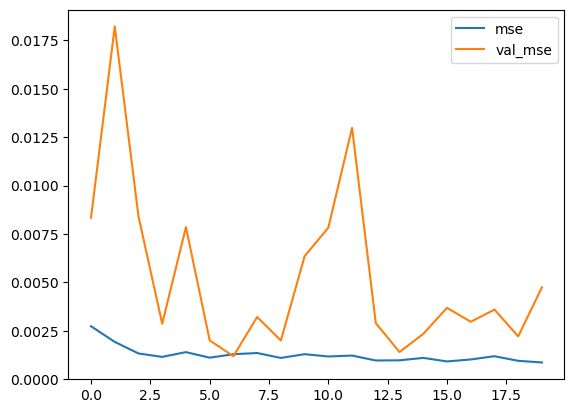

In [69]:
for i in ["loss","mse"]:
    plt.plot(hist3[i],label = i)
    plt.plot(hist3["val_"+i],label = "val_"+i)
    plt.legend()
    plt.show()

1/1 [==============================] - 1s 836ms/step


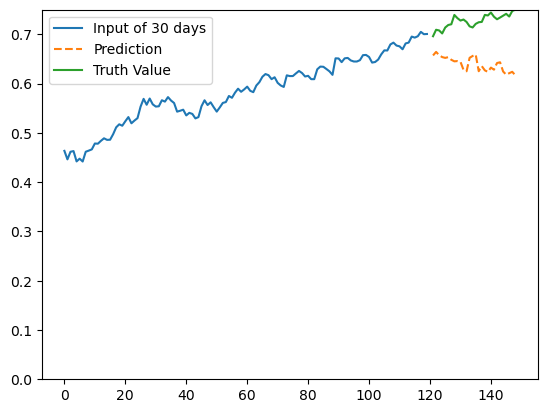

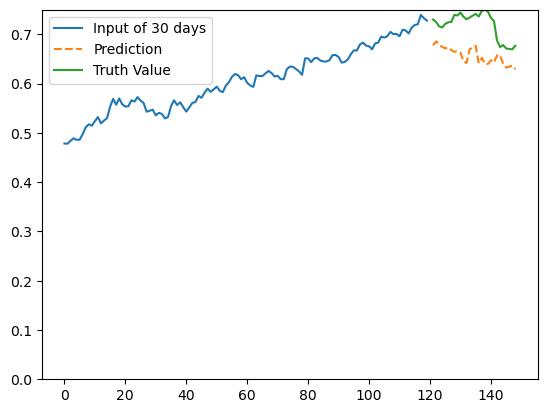

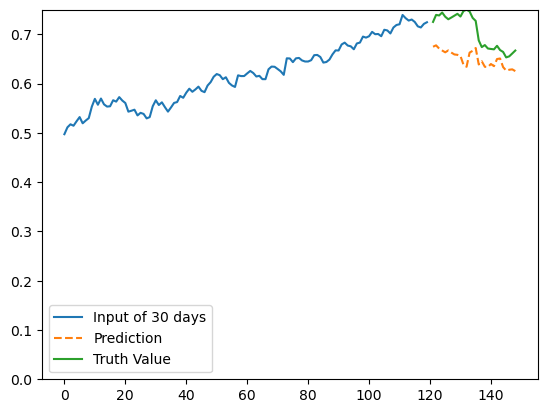

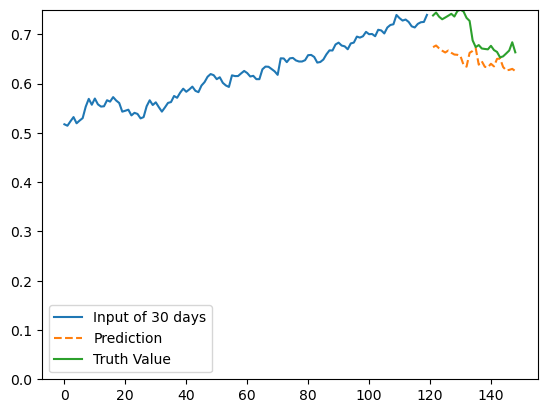

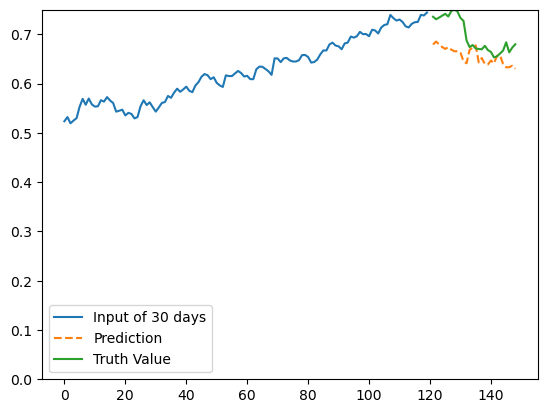

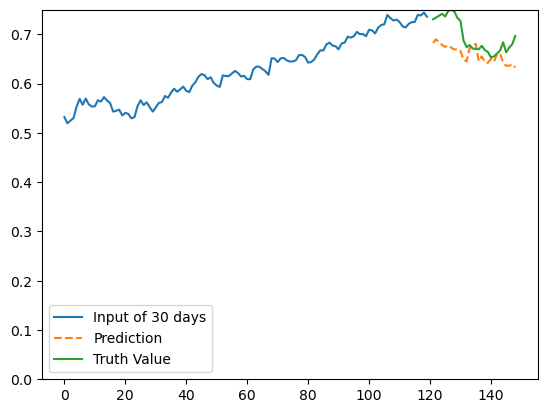

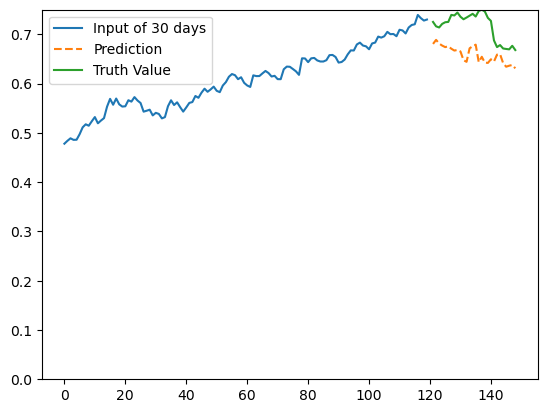

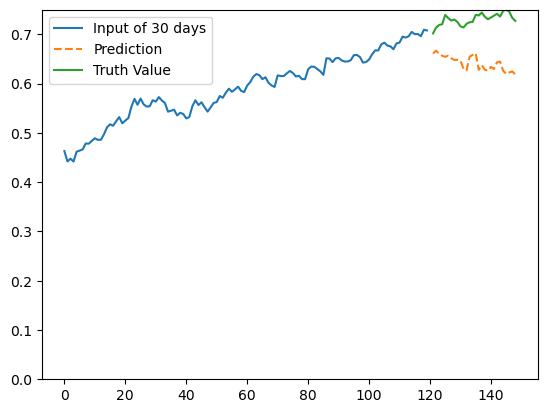

In [70]:
def visualplotloss4(dataset):
    x,y = next(iter(dataset))
    output = model4.predict(x)
    timecorr =list(range(121,149))
    for j in range(8):
        plt.ylim(0,0.75)
        plt.plot(x[j])
        plt.plot(timecorr,output[j],"--")
        plt.plot(timecorr,y[j])
        plt.legend(["Input of 30 days","Prediction","Truth Value"])
        plt.show()

visualplotloss4(test4batches)

1/1 [==============================] - 0s 74ms/step


Text(0.5, 1.0, 'Prediction for 28 Days')

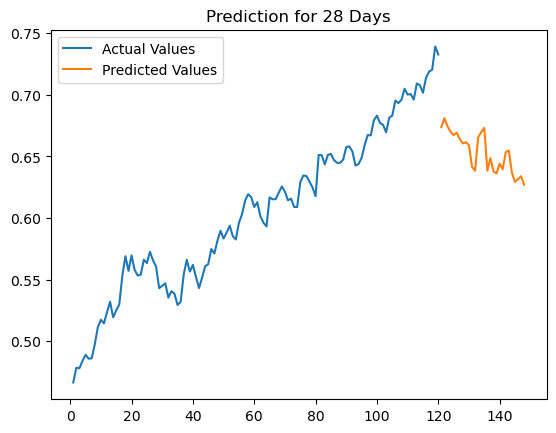

In [71]:
x4,y4 = next(iter(test4batches))
output4 = model4.predict(x4)

time=list(range(1,121))
time2=list(range(121,149))
plt.plot(time,x4[0])
plt.plot(time2,output4[0])
plt.legend(['Actual Values','Predicted Values'])
plt.title('Prediction for 28 Days')

In [72]:
model4.save('Model_4_Pred28_Days.h5')

In [73]:
#Model 5:
def windowed_dataset4(series, window_size = 150,predday = 35, batch_size = 32, shuffle_buffer= 1000):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + predday, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + predday))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-35], tf.squeeze(w[-35:])))
    return ds.batch(batch_size).prefetch(3)

train5batches =  windowed_dataset4(closetrain)
test5batches =  windowed_dataset4(closetest,batch_size=8)

from tensorflow.keras import layers

tf.keras.backend.clear_session()

tf.random.set_seed(35)
np.random.seed(35)

model5 = tf.keras.Sequential()
model5.add(layers.Conv1D(128,5,1,padding = "causal",activation = "relu",input_shape=[None, 1]))
for j in [128,128]:
    model5.add(layers.LSTM(j, return_sequences=True))
model5.add(layers.LSTM(128))
for i in [64,64,35]:
    model5.add(layers.Dense(i, activation="selu"))

print(model5.summary())



optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
kl = l = tf.keras.losses.LogCosh()
model5.compile(optimizer = 'adam', loss =tf.keras.losses.Huber(), metrics=["mse"])
h4 = model5.fit(train5batches,epochs=15,validation_data=test5batches,verbose=1)
hist4 = h4.history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 128)         768       
                                                                 
 lstm (LSTM)                 (None, None, 128)         131584    
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 35)                2

None
Epoch 1/15
54/54 [==============================] - 25s 403ms/step - loss: 0.0016 - mse: 0.0033
Epoch 2/15
54/54 [==============================] - 20s 365ms/step - loss: 8.2457e-04 - mse: 0.0016
Epoch 3/15
54/54 [==============================] - 20s 368ms/step - loss: 8.1815e-04 - mse: 0.0016
Epoch 4/15
54/54 [==============================] - 20s 371ms/step - loss: 7.8689e-04 - mse: 0.0016
Epoch 5/15
54/54 [==============================] - 24s 442ms/step - loss: 6.6292e-04 - mse: 0.0013
Epoch 6/15
54/54 [==============================] - 21s 379ms/step - loss: 7.7986e-04 - mse: 0.0016
Epoch 7/15
54/54 [==============================] - 20s 374ms/step - loss: 6.2421e-04 - mse: 0.0012
Epoch 8/15
54/54 [==============================] - 20s 369ms/step - loss: 5.9484e-04 - mse: 0.0012
Epoch 9/15
54/54 [==============================] - 20s 363ms/step - loss: 5.9017e-04 - mse: 0.0012
Epoch 10/15
54/54 [==============================] - 20s 364ms/step - loss: 6.2103e-04 - mse: 0.001

KeyError: 'val_loss'

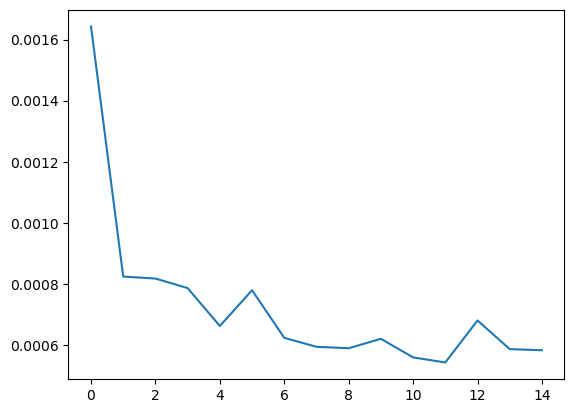

In [74]:
for i in ["loss","mse"]:
    plt.plot(hist4[i],label = i)
    plt.plot(hist4["val_"+i],label = "val_"+i)
    plt.legend()
    plt.show()

In [ ]:
def visualplotloss5(dataset):
    x,y = next(iter(dataset))
    output = model5.predict(x)
    timecorr =list(range(151,186))
    for j in range(8):
        plt.ylim(0,0.75)
        plt.plot(x[j])
        plt.plot(timecorr,output[j],"--")
        plt.plot(timecorr,y[j])
        plt.legend(["Input of 30 days","Prediction","Truth Value"])
        plt.show()

visualplotloss5(test5batches)

In [75]:
x5,y5 = next(iter(test5batches))
output5 = model5.predict(x5)

time=list(range(1,151))
time2=list(range(151,186))
plt.plot(time,x5[0])
plt.plot(time2,output5[0])
plt.legend(['Actual Values','Predicted Values'])
plt.title('Prediction for 35 Days')

StopIteration: 

In [76]:
model5.save('Model5_Pred_35Days.h5')